In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

In [2]:
features = xr.open_zarr("data/features.zarr")
targets = xr.open_zarr("data/targets.zarr")

D:\ML2025\PCPP\.venv\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
D:\ML2025\PCPP\.venv\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


In [3]:
matching_dims = {}
for dim in ['station', 'forecast_reference_time', 't']:
    if dim in features.dims and dim in targets.dims:
        features_len = len(features[dim])
        targets_len = len(targets[dim])
        match = features_len == targets_len
        matching_dims[dim] = match
        print(f"Dimension '{dim}': Features ({features_len}) - Targets ({targets_len}) - Match: {match}")
    else:
        missing = []
        if dim not in features.dims:
            missing.append("Features")
        if dim not in targets.dims:
            missing.append("Targets")
        print(f"Dimension '{dim}' missing here: {', '.join(missing)}")

Dimension 'station': Features (183) - Targets (183) - Match: True
Dimension 'forecast_reference_time': Features (21) - Targets (21) - Match: True
Dimension 't': Features (21) - Targets (21) - Match: True


In [4]:
important_coords = ['longitude', 'latitude', 'elevation', 'model_height_difference']
matching_coords = {}

In [5]:
for coord in important_coords:
    if coord in features.coords and coord in targets.coords:
        # Numpy dizilerine dönüştür ve karşılaştır
        features_values = features[coord].values
        targets_values = targets[coord].values

        # Dizilerin şekli aynı mı kontrol et
        if features_values.shape == targets_values.shape:
            # Tüm değerler aynı mı kontrol et
            is_equal = np.array_equal(features_values, targets_values)
            matching_coords[coord] = is_equal
            print(f"Coordinates '{coord}': {'✓ matching' if is_equal else '✗ does not match'}")
        else:
            matching_coords[coord] = False
            print(
                f"Coordinates '{coord}': ✗ Dimension incompatibility - Features {features_values.shape}, Targets {targets_values.shape}")
    else:
        missing = []
        if coord not in features.coords:
            missing.append("Features")
        if coord not in targets.coords:
            missing.append("Targets")
        matching_coords[coord] = False
        print(f"Coordinates '{coord}' missing here: {', '.join(missing)}")

Coordinates 'longitude': ✓ matching
Coordinates 'latitude': ✓ matching
Coordinates 'elevation': ✓ matching
Coordinates 'model_height_difference': ✓ matching


In [6]:
var_mappings = {
    'air_temperature': ('coe_air_temperature_ensavg', 'obs_air_temperature'),
    'dew_point_temperature': ('coe_dew_point_temperature_ensavg', 'obs_dew_point_temperature'),
    'surface_air_pressure': ('coe_surface_air_pressure_ensavg', 'obs_surface_air_pressure'),
    'relative_humidity': ('coe_relative_humidity_ensavg', 'obs_relative_humidity'),
    'water_vapor_mixing_ratio': ('coe_water_vapor_mixing_ratio_ensavg', 'obs_water_vapor_mixing_ratio')
}

In [7]:
for key, (feature_var, target_var) in var_mappings.items():
    print(f"\nVariable: {key}")

    # Features ve targets'da değişkenin varlığını kontrol et
    feature_exists = feature_var in features
    target_exists = target_var in targets

    if feature_exists and target_exists:
        # İstatistiksel özet
        feature_stats = {
            'min': float(features[feature_var].min().values),
            'max': float(features[feature_var].max().values),
            'mean': float(features[feature_var].mean().values),
            'std': float(features[feature_var].std().values)
        }

        target_stats = {
            'min': float(targets[target_var].min().values),
            'max': float(targets[target_var].max().values),
            'mean': float(targets[target_var].mean().values),
            'std': float(targets[target_var].std().values)
        }

        print(f"  Features ({feature_var}):")
        print(f"    Min: {feature_stats['min']:.2f}, Max: {feature_stats['max']:.2f}")
        print(f"    Mean: {feature_stats['mean']:.2f}, Std: {feature_stats['std']:.2f}")

        print(f"  Targets ({target_var}):")
        print(f"    Min: {target_stats['min']:.2f}, Max: {target_stats['max']:.2f}")
        print(f"    Mean: {target_stats['mean']:.2f}, Std: {target_stats['std']:.2f}")

        # Değer aralığı makul mu?
        reasonable_range = True

        if key == 'air_temperature' and (target_stats['min'] < -50 or target_stats['max'] > 50):
            reasonable_range = False
            print("  ⚠️ Temperature values are wrong (-50°C - 50°C)")

        elif key == 'dew_point_temperature' and (target_stats['min'] < -50 or target_stats['max'] > 50):
            reasonable_range = False
            print("  ⚠️ Dew point temperature values are wrong (-50°C - 50°C)")

        elif key == 'surface_air_pressure' and (target_stats['min'] < 500 or target_stats['max'] > 1100):
            reasonable_range = False
            print("  ⚠️ Pressure values are wrong (500 hPa - 1100 hPa)")

        elif key == 'relative_humidity' and (target_stats['min'] < 0 or target_stats['max'] > 100):
            reasonable_range = False
            print("  ⚠️ Relative Humidity values are wrong (0% - 100%)")

        elif key == 'water_vapor_mixing_ratio' and (target_stats['min'] < 0 or target_stats['max'] > 50):
            reasonable_range = False
            print("  ⚠️ Water Vapor Mixing Ratio is wrong (0 - 50 g/kg)")

        if reasonable_range:
            print("  ✓ Values are in correct range.")

    else:
        if not feature_exists:
            print(f"  ✗ Variable '{feature_var}' can't be located in the features dataset.")
        if not target_exists:
            print(f"  ✗ Variable '{target_var}' can't be located in the targets dataset.")


Variable: air_temperature
  Features (coe_air_temperature_ensavg):
    Min: -9.70, Max: 23.40
    Mean: 8.51, Std: 5.43
  Targets (obs_air_temperature):
    Min: -9.88, Max: 23.57
    Mean: 8.50, Std: 5.46
  ✓ Values are in correct range.

Variable: dew_point_temperature
  Features (coe_dew_point_temperature_ensavg):
    Min: -13.29, Max: 13.04
    Mean: 4.39, Std: 4.12
  Targets (obs_dew_point_temperature):
    Min: -13.10, Max: 14.28
    Mean: 4.38, Std: 4.19
  ✓ Values are in correct range.

Variable: surface_air_pressure
  Features (coe_surface_air_pressure_ensavg):
    Min: 1013.25, Max: 1013.25
    Mean: 1013.25, Std: 0.00
  Targets (obs_surface_air_pressure):
    Min: 1011.13, Max: 1015.51
    Mean: 1013.25, Std: 0.52
  ✓ Values are in correct range.

Variable: relative_humidity
  Features (coe_relative_humidity_ensavg):
    Min: 27.11, Max: 100.00
    Mean: 77.10, Std: 14.52
  Targets (obs_relative_humidity):
    Min: 23.15, Max: 100.00
    Mean: 77.09, Std: 14.61
  ✓ Values a

In [13]:
# August-Roche-Magnus equation values
a_pos = 17.368
b_pos = 238.83
c_pos = 6.107  # hPa
a_neg = 17.856
b_neg = 245.52
c_neg = 6.108  # hPa

In [8]:
required_vars = ['obs_air_temperature', 'obs_dew_point_temperature',
                 'obs_surface_air_pressure', 'obs_relative_humidity',
                 'obs_water_vapor_mixing_ratio']

In [9]:
all_vars_exist = all(var in targets for var in required_vars)

1. Dew point is not higher than temperature: ✓ YES
2. Relative humidity between 0–100%: ✓ YES
3. Relative humidity consistency (difference between calculated RH and provided RH):
   Average difference: 0.00%
   Maximum difference: 0.00%
   Consistency: ✓ GOOD
4. Water vapor mixing ratio consistency (difference between calculated r and provided r):
   Average difference: 0.00 g/kg
   Maximum difference: 0.00 g/kg
   Consistency: ✓ GOOD

Graphic Analysis is Saved


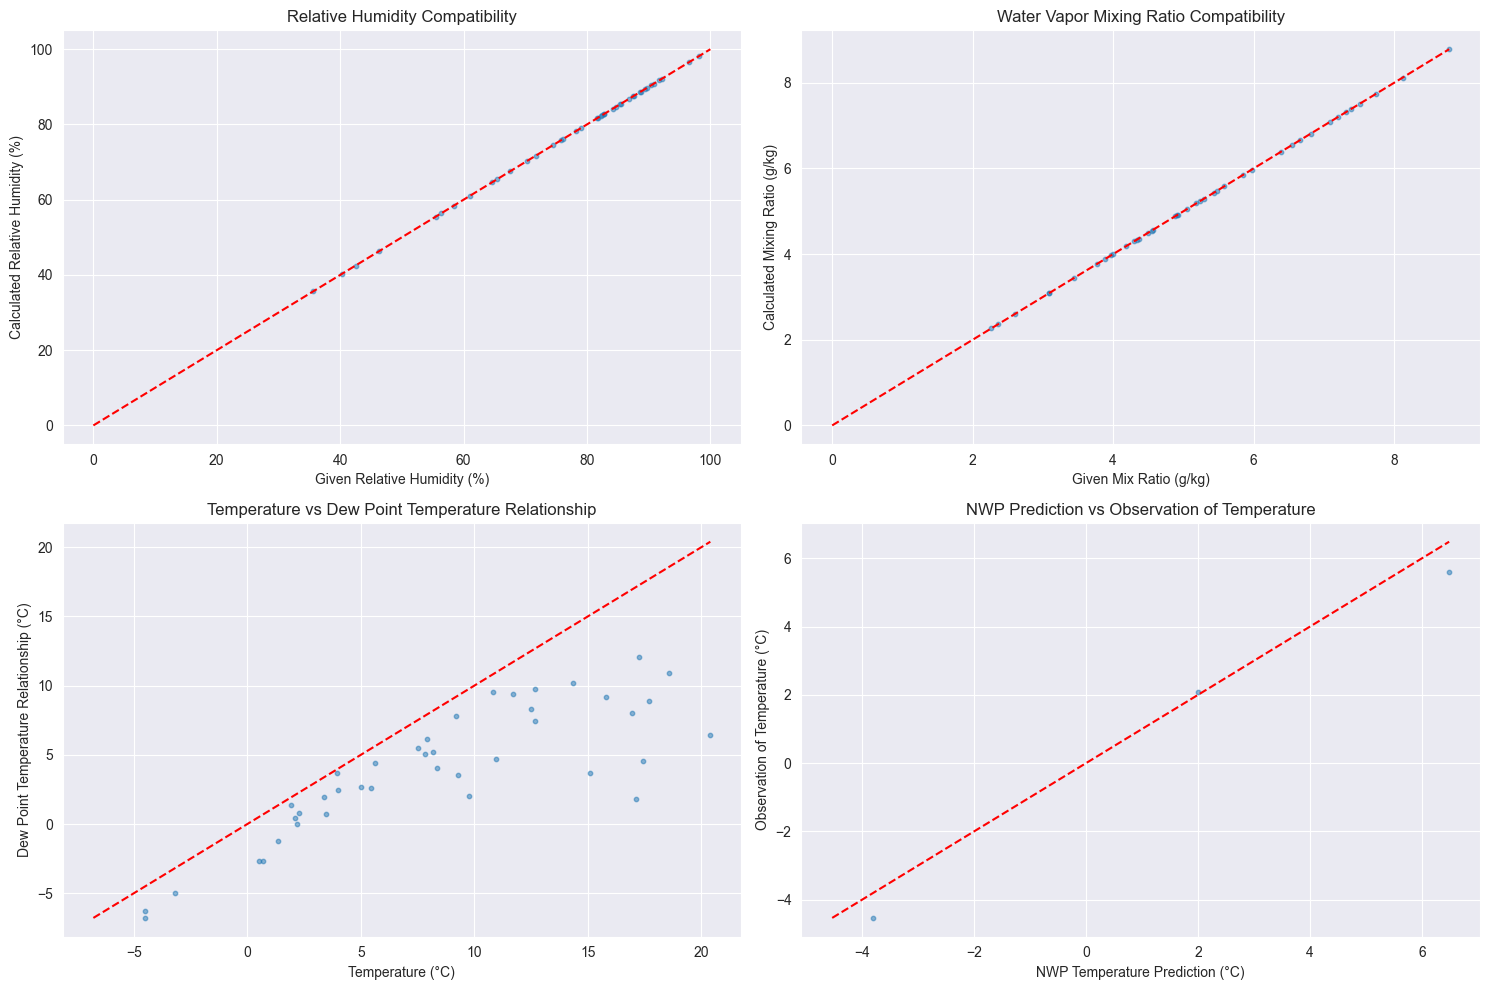

In [14]:
if all_vars_exist:
    sample_size = min(1000, len(targets.station) * len(targets.t))

    station_indices = np.random.choice(len(targets.station), size=sample_size, replace=True)
    t_indices = np.random.choice(len(targets.t), size=sample_size, replace=True)
    time_indices = np.random.choice(len(targets.forecast_reference_time), size=sample_size, replace=True)

    T = np.array([targets['obs_air_temperature'].values[s, ti, tt]
                  for s, ti, tt in zip(station_indices, time_indices, t_indices)])
    Td = np.array([targets['obs_dew_point_temperature'].values[s, ti, tt]
                   for s, ti, tt in zip(station_indices, time_indices, t_indices)])
    P = np.array([targets['obs_surface_air_pressure'].values[s, ti, tt]
                  for s, ti, tt in zip(station_indices, time_indices, t_indices)])
    RH = np.array([targets['obs_relative_humidity'].values[s, ti, tt]
                   for s, ti, tt in zip(station_indices, time_indices, t_indices)])
    r = np.array([targets['obs_water_vapor_mixing_ratio'].values[s, ti, tt]
                  for s, ti, tt in zip(station_indices, time_indices, t_indices)])

    valid_idx = ~np.isnan(T) & ~np.isnan(Td) & ~np.isnan(P) & ~np.isnan(RH) & ~np.isnan(r)
    T = T[valid_idx]
    Td = Td[valid_idx]
    P = P[valid_idx]
    RH = RH[valid_idx]
    r = r[valid_idx]

    if len(T) > 0:
        td_valid = np.all(Td <= T)
        print(f"1. Dew point is not higher than temperature: {'✓ YES' if td_valid else '✗ NO'}")
        if not td_valid:
            invalid_count = np.sum(Td > T)
            print(f"   ⚠️ Dew point exceeds temperature in {invalid_count} sample(s)")

        rh_valid = np.all((RH >= 0) & (RH <= 100))
        print(f"2. Relative humidity between 0–100%: {'✓ YES' if rh_valid else '✗ NO'}")
        if not rh_valid:
            invalid_low = np.sum(RH < 0)
            invalid_high = np.sum(RH > 100)
            print(f"   ⚠️ In {invalid_low} sample(s) RH < 0%, in {invalid_high} sample(s) RH > 100%")

        a = np.where(T >= 0, a_pos, a_neg)
        b = np.where(T >= 0, b_pos, b_neg)

        calculated_RH = 100 * np.exp((a * Td) / (b + Td)) / np.exp((a * T) / (b + T))
        rh_diff = np.abs(calculated_RH - RH)
        rh_consistency = np.mean(rh_diff)

        print("3. Relative humidity consistency (difference between calculated RH and provided RH):")
        print(f"   Average difference: {rh_consistency:.2f}%")
        print(f"   Maximum difference: {np.max(rh_diff):.2f}%")
        print(f"   Consistency: {'✓ GOOD' if rh_consistency < 5 else '⚠️ MODERATE' if rh_consistency < 10 else '✗ POOR'}")

        c = np.where(T >= 0, c_pos, c_neg)
        e = c * np.exp((a * Td) / (b + Td))
        calculated_r = 622.0 * e / (P - e + 1e-6)
        r_diff = np.abs(calculated_r - r)
        r_consistency = np.mean(r_diff)

        print("4. Water vapor mixing ratio consistency (difference between calculated r and provided r):")
        print(f"   Average difference: {r_consistency:.2f} g/kg")
        print(f"   Maximum difference: {np.max(r_diff):.2f} g/kg")
        print(f"   Consistency: {'✓ GOOD' if r_consistency < 0.5 else '⚠️ MODERATE' if r_consistency < 1 else '✗ POOR'}")


        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.scatter(RH, calculated_RH, alpha=0.5, s=10)
        plt.plot([0, 100], [0, 100], 'r--')
        plt.xlabel('Given Relative Humidity (%)')
        plt.ylabel('Calculated Relative Humidity (%)')
        plt.title('Relative Humidity Compatibility')
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.scatter(r, calculated_r, alpha=0.5, s=10)
        max_val = max(np.max(r), np.max(calculated_r))
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xlabel('Given Mix Ratio (g/kg)')
        plt.ylabel('Calculated Mixing Ratio (g/kg)')
        plt.title('Water Vapor Mixing Ratio Compatibility')
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.scatter(T, Td, alpha=0.5, s=10)
        min_val = min(np.min(T), np.min(Td))
        max_val = max(np.max(T), np.max(Td))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Dew Point Temperature Relationship (°C)')
        plt.title('Temperature vs Dew Point Temperature Relationship')
        plt.grid(True)

        if 'coe_air_temperature_ensavg' in features:
            plt.subplot(2, 2, 4)
            f_sample = []
            t_sample = []

            for s, ti, tt in zip(station_indices[:100], time_indices[:100], t_indices[:100]):
                try:
                    f_val = features['coe_air_temperature_ensavg'].values[s, ti, tt]
                    t_val = targets['obs_air_temperature'].values[s, ti, tt]
                    if not np.isnan(f_val) and not np.isnan(t_val):
                        f_sample.append(f_val)
                        t_sample.append(t_val)
                except IndexError:
                    continue

            if len(f_sample) > 0:
                plt.scatter(f_sample, t_sample, alpha=0.5, s=10)
                min_val = min(np.min(f_sample), np.min(t_sample))
                max_val = max(np.max(f_sample), np.max(t_sample))
                plt.plot([min_val, max_val], [min_val, max_val], 'r--')
                plt.xlabel('NWP Temperature Prediction (°C)')
                plt.ylabel('Observation of Temperature (°C)')
                plt.title('NWP Prediction vs Observation of Temperature')
                plt.grid(True)

        plt.tight_layout()
        plt.savefig('data-compatibility-analysis.png', dpi=300, bbox_inches='tight')
        print(f"\nGraphic Analysis is Saved")
    else:
        print("✗ There is not enough data.")
else:
    print("✗ Some of the necessary variables are missing from the targets dataset:")
    for var in required_vars:
        if var not in targets:
            print(f"  - '{var}' is missing")